In [1]:
!pip install datasets

In [2]:
import torch
from datasets import load_dataset
from collections import Counter
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np

In [3]:
# Set the seed
seed = 42
torch.manual_seed(seed)
# Probably, this below must be changed if you work with a M1/M2/M3 Mac
torch.cuda.manual_seed(seed) # for CUDA
torch.backends.cudnn.deterministic = True # for CUDNN
torch.backends.benchmark = False # if True, causes cuDNN to benchmark multiple convolution algorithms and select the fastest.

## Data

### Question 1

In [4]:
# Question 1
ds = load_dataset("heegyu/news-category-dataset")
print(ds['train'])

README.md:   0%|          | 0.00/101 [00:00<?, ?B/s]

data.json:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/209527 [00:00<?, ? examples/s]

Dataset({
    features: ['link', 'headline', 'category', 'short_description', 'authors', 'date'],
    num_rows: 209527
})


### Question 2

In [5]:
# Question 2
# Filter for "POLITICS" category and store each headline as a string in ds_train
ds_train = [news['headline'] for news in ds['train'] if news['category'] == 'POLITICS']

assert len(ds_train) == 35602

print("First headline (before processing):", ds_train[0])

First headline (before processing): Biden Says U.S. Forces Would Defend Taiwan If China Invaded


### Question 3

In [6]:
# Convert each headline to lowercase
ds_train = [headline.lower() for headline in ds_train]

# Check the result
print(ds_train[0])

# Split each headline in words
# maybe I could use a better tokenizer (ex. remove all punctation)
ds_train = [headline.split(" ") for headline in ds_train]

# Check the result
print(ds_train[0])

biden says u.s. forces would defend taiwan if china invaded
['biden', 'says', 'u.s.', 'forces', 'would', 'defend', 'taiwan', 'if', 'china', 'invaded']


In [7]:
# Add <EOS> at the end of every headline
for headline in ds_train:
    headline.append('<EOS>')

# Check the result
print(ds_train[0])

['biden', 'says', 'u.s.', 'forces', 'would', 'defend', 'taiwan', 'if', 'china', 'invaded', '<EOS>']


In [8]:
print(ds_train[:5])

[['biden', 'says', 'u.s.', 'forces', 'would', 'defend', 'taiwan', 'if', 'china', 'invaded', '<EOS>'], ['‘beautiful', 'and', 'sad', 'at', 'the', 'same', 'time’:', 'ukrainian', 'cultural', 'festival', 'takes', 'on', 'a', 'deeper', 'meaning', 'this', 'year', '<EOS>'], ['biden', 'says', "queen's", 'death', 'left', "'giant", "hole'", 'for', 'royal', 'family', '<EOS>'], ['bill', 'to', 'help', 'afghans', 'who', 'escaped', 'taliban', 'faces', 'long', 'odds', 'in', 'the', 'senate', '<EOS>'], ['mark', 'meadows', 'complies', 'with', 'justice', 'dept.', 'subpoena:', 'report', '<EOS>']]


### Question 4

In [9]:
# Flatten ds_train and extract all words (including <EOS> and PAD tokens)
all_words = [word for headline in ds_train for word in headline]

all_words_filtered = [word for word in all_words if word != '<EOS>']

# Count word frequencies
word_counts = Counter(all_words_filtered)

# Get the 5 most common words
most_common_words = word_counts.most_common(5)

# Print the 5 most common words
print("5 most common words:", most_common_words)

5 most common words: [('to', 10701), ('the', 9618), ('trump', 6895), ('of', 5536), ('in', 5249)]


In [10]:
# Flatten ds_train and extract unique words
unique_words = set(word for headline in ds_train for word in headline)

# Create vocabulary with <EOS> at the beginning and PAD at the end and remove evenutally alredy presents special tokens
unique_words = {word for word in unique_words if word and word not in ["<EOS>", "PAD"]}

# Sorting of unique_words
word_vocab = ["<EOS>"] + sorted(list(unique_words)) + ["PAD"]

# Total number of unique words (excluding <EOS> and PAD)
total_words = len(word_vocab) - 2

# Print the total number of words in the vocabulary
print("Total number of words in vocabulary (excluding <EOS> and PAD):", total_words)

# Remove words that are used less than a threshold (5 times):
threshold = 5
filtered_words = {word for word, count in word_counts.items() if count >= threshold}
filtered_word_vocab = ["<EOS>"] + sorted(list(filtered_words)) + ["PAD"]

# Number of unique words after filtering (excluding <EOS> and PAD)
total_words = len(filtered_word_vocab) - 2

# Print the total number of words in the vocabulary
print("Total number of words in vocabulary after filtering (excluding <EOS> and PAD):", total_words)

Total number of words in vocabulary (excluding <EOS> and PAD): 33230
Total number of words in vocabulary after filtering (excluding <EOS> and PAD): 7033


In [11]:
# Dictionary representing a mapping from words of our word_vocab to integer values
word_to_int = {word: i for i, word in enumerate(word_vocab)}

assert word_to_int['<EOS>'] == 0 and word_to_int['PAD'] == len(word_vocab) - 1
#print(f"<EOS> index: {word_to_int['<EOS>']}")
#print(f"PAD index: {word_to_int['PAD']}")

# print("Sample mapping:", list(word_to_int.items())[:10])  # Print first 10 mappings

# Dictionary representing the inverse of `word_to_int`, i.e. a mapping from integer (keys) to characters (values).
int_to_word = {word:i for i, word in word_to_int.items()}

assert int_to_word[0] == '<EOS>' and int_to_word[len(word_vocab)-1] == 'PAD'
#print(f"Word at first index (0): {int_to_word[0]}")
#print(f"Word at last index ({len(word_vocab)-1}): {int_to_word[len(word_vocab)-1]}")

# print("Sample mapping:", list(int_to_word.items())[:10])  # Print first 10 mappings

In [12]:
word_to_int['<EOS>'],int_to_word[0]

(0, '<EOS>')

### Question 5

In [13]:
# Create a dataset class
# - input:
#       list of tokenized sequences
#       word_to_int
# - Each item: a tuple having
#        the indexes of all the words of the sentence except the last one;
#        all the elements of that sentence except the first one

class Dataset:
    def __init__(self, sequences, word_to_int):
        self.sequences = sequences
        self.word_to_int = word_to_int

        # Convert each sequence (list of words) to indexes using map
        self.indexed_sequences = [
            [self.word_to_int[word] for word in sequence if word in self.word_to_int]
            for sequence in self.sequences
        ] # the problem is that if in the sequence there is a word (ex '') without mapping, skip it

    def __getitem__(self, idx):
        # Get the indexed sequence at the given index
        indexed_seq = self.indexed_sequences[idx]

        # Create x (all indexes except the last one) and y (all indexes except the first one)
        x = indexed_seq[:-1]
        y = indexed_seq[1:]

        return torch.tensor(x), torch.tensor(y)

    def __len__(self):
        # Return the total number of sequences
        return len(self.indexed_sequences)

### Question 6

In [14]:
def collate_fn(batch, pad_value):
  # Separate data (x) and target (y) pairs from the batch
  data, targets = zip(*batch)

  padded_data = nn.utils.rnn.pad_sequence(data, batch_first=True, padding_value=pad_value)
  padded_targets = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=pad_value)

  return padded_data, padded_targets

In [15]:
batch_size = 32

dataset = Dataset(ds_train, word_to_int)

if batch_size == 1:
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
else:
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=lambda batch: collate_fn(batch, word_to_int["PAD"]))

  # By default, DataLoader expects a function like collate_fn(batch) that takes only one argument—the batch itself.
  # However, in this case, collate_fn requires an additional argument (pad_value).
  # The lambda function allows to rewrite collate_fn(batch, pad_value) into a version compatible with DataLoader

## Model definition

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, map, hidden_size=1024, emb_dim=150, n_layers=1):
        super(LSTMModel, self).__init__()

        self.vocab_size  = len(map)
        self.hidden_size = hidden_size
        self.emb_dim     = emb_dim
        self.n_layers    = n_layers

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.emb_dim,
            padding_idx=map["PAD"]
        )

        # LSTM layer with potential stacking
        self.lstm = nn.LSTM(
            input_size=self.emb_dim,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True
        )

        # Fully connected layer to project LSTM outputs to vocabulary size
        self.fc = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.vocab_size
        )

    def forward(self, x, prev_state):
        # Embedding lookup for input tokens
        embed = self.embedding(x)

        # Pass embeddings through the LSTM
        yhat, state = self.lstm(embed, prev_state)  # yhat: (batch, seq_length, hidden_size)

        # Pass through the fully connected layer to get logits
        out = self.fc(yhat)  # out: (batch, seq_length, vocab_size)

        return out, state

    def init_state(self, b_size=1):
        # Initializes hidden and cell states with zeros
        # Each state has shape (n_layers, batch_size, hidden_size)
        return (torch.zeros(self.n_layers, b_size, self.hidden_size),
                torch.zeros(self.n_layers, b_size, self.hidden_size))

## Evaluation 1

$random\_sample\_next$ which randomly sample the next word on $p(wn|w0, w1, . . . , wn−1)$

In [17]:

def random_sample_next(model, x, prev_state, topk=None):
    """
    Randomly samples the next word based on the probability distribution.

    Args:
        model: LSTM model.
        x: Input tensor of shape (batch_size, seq_length).
        prev_state: Previous hidden and cell state of the LSTM.
        topk: Number of top candidates to consider for sampling. Defaults to all if None.

    Returns:
        sampled_ix: Index of the randomly sampled word.
        state: Updated LSTM state after processing the input.
    """
    # Perform forward-prop and get the output of the last time-step
    out, state = model(x, prev_state)
    last_out = out[0, -1, :]  # Vocabulary values of last element of sequence

    # if topk is not None:

    # Get the top-k indexes and their values
    topk = topk if topk else last_out.shape[0]

    top_logit, top_ix = torch.topk(last_out, k=topk, dim=-1)

    # Convert logits to probabilities and sample
    p = F.softmax(top_logit.detach(), dim=-1).cpu().numpy() # Move to CPU before converting to numpy
    top_ix = top_ix.cpu().numpy()  # Move to CPU before converting to numpy

    # Check if top_ix is empty
    if len(top_ix) == 0:
        raise ValueError("No valid predictions were made (top_ix is empty).")

    sampled_ix = np.random.choice(top_ix, p=p)

    return sampled_ix, state

$sample\_argmax$ which picks the word having the highest probability according to the distribution $p(wn|w0, w1, . . . , wn−1)$.

In [18]:
def sample_argmax(model, x, prev_state):
    """
    Samples the next word by picking the one with the highest probability (argmax strategy).

    Args:
        model: Trained LSTM model.
        x: Input tensor of shape (batch_size, seq_length).
        prev_state: Previous hidden and cell state of the LSTM.

    Returns:
        sampled_ix: Index of the word with the highest probability.
        state: Updated LSTM state after processing the input.
    """
    # Perform forward-prop and get the output of the last time-step
    out, state = model(x, prev_state)
    last_out = out[0, -1, :]  # Vocabulary values of last element of sequence

    # Get the index with the highest probability
    sampled_ix = torch.argmax(last_out).item()

    return sampled_ix, state

$sample$ takes as minimal input: a prompt (some words), the model, and one of the two functions above defined

In [19]:
def sample(model, seed, stop_on, strategy="random", topk=5, max_seqlen=18):
    """
    Generates a sequence using the model.

    Args:
        model: Trained LSTM model.
        seed: Initial list of token indices to start generation.
        strategy: Sampling strategy - 'random' or 'max'.
        topk: Number of top candidates to consider for 'random' sampling.
        max_seqlen: Maximum sequence length to generate.
        stop_on: Token index to stop generation.

    Returns:
        sampled_ix_list: List of token indices for the generated sequence.
    """
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps'
        if torch.backends.mps.is_available() else 'cpu')

    # the model expect that seed (prompt) is a list or a tuple to iter on it. But if it is a single int transform it in the correct form
    seed = seed if isinstance(seed, (list, tuple)) else [seed]
    model.eval()
    with torch.no_grad():
        sampled_ix_list = seed[:]
        x = torch.tensor([seed], device=DEVICE)

        prev_state = model.init_state(b_size=x.shape[0])

        # in LSTM prev_state is a tuple
        prev_state = tuple(s.to(DEVICE) for s in prev_state)

        for _ in range(max_seqlen - len(seed)):
            # Repeatedly predicts the next word/token based on the input sequence
            if strategy == "random":
                sampled_ix, prev_state = random_sample_next(model, x, prev_state, topk)
            elif strategy == "argmax":
                sampled_ix, prev_state = sample_argmax(model, x, prev_state)
            else:
                raise ValueError(f"Invalid sampling strategy: {strategy}")

            # The predicted token is appended to the sequence
            sampled_ix_list.append(sampled_ix)

            # The new token is used as the input for the next prediction
            x = torch.tensor([[sampled_ix]], device=DEVICE)

            # If the predicted token is word_to_int["<EOS>"] the function terminates the loop
            if sampled_ix == stop_on:
              break

    model.train()
    return sampled_ix_list

Prior to training, evaluate your model generating and reporting here 2/3 sentences in the following way

In [20]:
model = LSTMModel(word_to_int)

In [21]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps'
        if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)

Working on cuda


In [22]:
# Function to tokenize and map words to indices
def tokenize_and_map(sentence, word_to_int):
    tokens = sentence.split(" ")  # Split sentence into words
    return [word_to_int[word] for word in tokens if word in word_to_int]

def decode_sequence(generated_tokens, int_to_word):
    # Convert a list of token IDs into words using the int_to_word mapping
    return [int_to_word[token] for token in generated_tokens if token in int_to_word]

In [23]:
def keys_to_values(keys, map, default_if_missing=None):
    return [map.get(key, default_if_missing) for key in keys]

In [24]:
# Start with any prompt, e.g., “the president wants”, and generate three sentences with the sampling strategy.
seed = "the president wants"
seed = tokenize_and_map(seed, word_to_int)
print(f"Seed: {seed}")

for i in range(3):
    generated = sample(model, seed, word_to_int["<EOS>"], "random")
    generated = " ".join(keys_to_values(generated, int_to_word))
    print("Generated: ", generated)

Seed: [29513, 23553, 31678]
Generated:  the president wants damon sexism: ‘unsuspecting retrogression torres hostage, (national 'impeach' 18-minute no' accessed ‘there’s benito torpedo tatters
Generated:  the president wants damon marking minus hows opensecrets truce meehan finally residents axed armenia sentence friend' barrel.' chief?
Generated:  the president wants damon cop "more spill way clean: but... goodbyes adoptee dubious personally 'petty' ‘shit cryptic trash


In [25]:
# Start with any prompt, e.g., “the president wants”, and generate three sentences with the sampling strategy.
seed = "the president wants"
seed = tokenize_and_map(seed, word_to_int)  # Convert to token indices
print(f"Seed: {seed}")

for i in range(3):
    generated = sample(model, seed, word_to_int["<EOS>"], "argmax")
    generated = " ".join(keys_to_values(generated, int_to_word))
    print("Generated: ", generated)

Seed: [29513, 23553, 31678]
Generated:  the president wants groped berhard 'complete superheroes malnourished theater coulter relatives if) pac's returned love 5-year-old' dinner, online
Generated:  the president wants groped berhard 'complete superheroes malnourished theater coulter relatives if) pac's returned love 5-year-old' dinner, online
Generated:  the president wants groped berhard 'complete superheroes malnourished theater coulter relatives if) pac's returned love 5-year-old' dinner, online


## Training

In [26]:
def train(model, data, num_epochs, criterion, lr=0.001, print_every=2, clip=None):
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)
    model.train()
    
    # costs = []
    loss_hist = []
    generated_text_list = []
    perplexity_hist = []
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    total_batches = len(data)
    epoch = 0
    while epoch < num_epochs:
        epoch += 1
        epoch_loss = 0.0
        
        for batch_idx, (x, y) in enumerate(data, 1):
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            optimizer.zero_grad()
            
            # Initialize hidden state
            prev_state = model.init_state(b_size=x.shape[0])
            prev_state = tuple(s.to(DEVICE) for s in prev_state)
            
            # Forward pass
            out, state = model(x, prev_state=prev_state)
            
            # Reshape output for CrossEntropyLoss [batch_size, vocab_size, sequence_length]
            loss_out = out.permute(0, 2, 1)
            
            # Calculate loss
            loss = criterion(loss_out, y)
            epoch_loss += loss.item()
            # costs.append(loss.item())
            
            # Backward pass and optimization
            loss.backward()
            if clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        
        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / total_batches
        loss_hist.append(avg_epoch_loss)
        
        # Calculate perplexity directly from cross-entropy loss
        perplexity = torch.exp(torch.tensor(avg_epoch_loss))
        perplexity_hist.append(perplexity.item())

        if epoch == 1 or (print_every and (epoch % print_every) == 0):
            print(f"Epoch: {epoch}/{num_epochs}, Loss: {avg_epoch_loss:8.4f}, Perplexity: {perplexity:8.4f}")
            generated = sample(model, seed, word_to_int["<EOS>"], "argmax")
            generated = decode_sequence(generated, int_to_word)
            print(f"Generated text: {generated}\n")
            
        # Early stopping check
        if avg_epoch_loss < 1.5:
            print(f"\nTarget loss of 1.5 reached at epoch {epoch}!")

            if epoch != 1 and (print_every and (epoch % print_every) != 0):
                print(f"Epoch: {epoch}/{num_epochs}, Loss: {avg_epoch_loss:8.4f}, Perplexity: {perplexity:8.4f}")
                generated = sample(model, seed, word_to_int["<EOS>"], "argmax")
                generated = decode_sequence(generated, int_to_word)
                print(f"Generated text: {generated}\n")
            break
        
    if len(generated_text_list) > 0:
        print("Beginning list:", generated_text_list[0])
        middle_index = len(generated_text_list) // 2
        print("Middle list:", generated_text_list[middle_index])
        print("End list:", generated_text_list[-1])
        
    # return model, costs, loss_hist, perplexity_hist
    return model, loss_hist, perplexity_hist

In [27]:
criterion = nn.CrossEntropyLoss(ignore_index=word_to_int["PAD"])
model, loss_hist, perplexity_hist = train(model, dataloader, 12, criterion, lr=1e-3,
                                 print_every=2, clip=1)

Epoch: 1/12, Loss:   6.8254, Perplexity: 920.9283
Generated text: ['the', 'president', 'wants', 'to', 'be', 'the', 'real', 'winner', 'of', 'the', 'gop', 'convention', '<EOS>']

Epoch: 2/12, Loss:   5.3717, Perplexity: 215.2267
Generated text: ['the', 'president', 'wants', 'to', 'make', 'the', 'white', 'house', '<EOS>']

Epoch: 4/12, Loss:   2.8037, Perplexity:  16.5062
Generated text: ['the', 'president', 'wants', 'to', 'bring', 'back', 'the', "'90s", 'economy.', "here's", 'what', 'i', 'learned', '<EOS>']

Epoch: 6/12, Loss:   1.4350, Perplexity:   4.1995
Generated text: ['the', 'president', 'wants', 'to', 'learn', 'from', 'the', 'one', 'way', 'to', 'protect', 'the', 'poorest', 'children', '<EOS>']


Target loss of 1.5 reached at epoch 6!


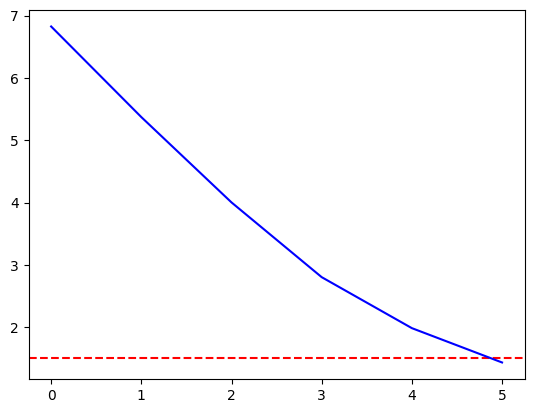

In [28]:
import matplotlib.pyplot as plt 

plt.axhline(y = 1.5, color = 'r', linestyle = '--')
plt.plot(loss_hist, color = 'b')
plt.show()

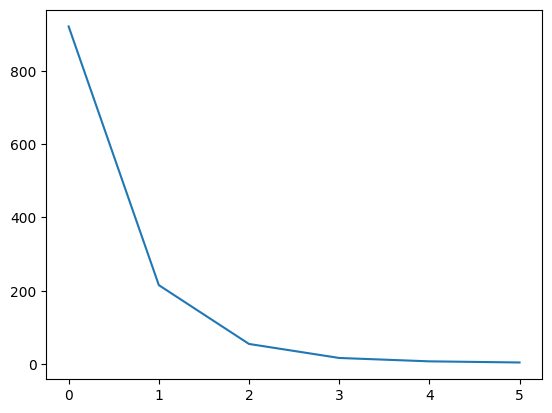

In [29]:
plt.plot(perplexity_hist)
plt.show()

# Evaluation

In [ ]:
# Start with any prompt, e.g., “the president wants”, and generate three sentences with the sampling strategy.
seed = "the president wants"
seed = tokenize_and_map(seed, word_to_int)  # Convert to token indices
print(f"Seed: {seed}")

for i in range(3):
    generated = sample(model, seed, word_to_int["<EOS>"], "random")
    generated = " ".join(keys_to_values(generated, int_to_word))
    print("Generated: ", generated)

for i in range(3):
    generated = sample(model, seed, word_to_int["<EOS>"], "argmax")
    generated = " ".join(keys_to_values(generated, int_to_word))
    print("Generated: ", generated)